# Destiny 2 Exotic Class Item Farm Analysis
*Finnley Autumn Rogers* | 2024-08-01

## Introduction

With the launch Destiny 2's most recent expansion, *the Final Shape*, came the addition of a new piece of armor known as the Exotic Class Item.

#### Background for non-destiny players

Destiny 2 is an Massively Multiplayer Online First Person Shooter (MMOFPS), where the player is incentivized to complete certain activities in order to recieve randomly generated 'loot', be it weapons or armor. There are three playable Classes that any player can choose (titan, warlock, hunter), and within those classes is a special 'class item', or a piece of armor that can only be worn by that particular class (e.g. Hunter's have cloaks, Warlocks have armbands, and Titans have a 'mark'). 

Each piece of armor can have different rarity values, where 'Exotic' is the rarest. Exotic armor provides a singular, powerful, unchanging, benefit (perk) for wearing, and as a result, only one piece of exotic armor can be worn at a time. 

This particular item, the Exotic Class item can be obtained from two different sources (I'll discuss that more later), and offers a combination of two pieces of exotic armor. Each Class gets their own version of this item, with slightly different perks available to each class. 

What makes this so unique is that, unlike usual exotic armor, the perks available on each class item are randomly selected each time the item is attained (coloquially referred to as a 'drop'). There are 2 perk 'columns', with 8 perks that can possibly appear in each column, for 64 total versions of the Exotic Class item *per class*.

Because of the potency of certain perk combinations, and the ever changing nature of an always-online video game, many different combinations are seen as desirable either to facilitate various playstyles, or simply from a completionist perspective. As such, the sources of the Class Item are heavily scrutinized by the playerbase, to reach an understanding of the 'most efficient' way to get a Class Item drop. 

In broad strokes there are two kinds of players pursuing different rolls of the Exotic Class Item.
1. Completionists: Players who will continue to grind until they have recieved all 64 possible versions of the item
2. Targeted Runners: Players who are looking for one specific combination of perks, and will stop pursuing the item once received.

Those are the two player cases I will examine in the rest of this analysis. 

I would like to acknowledge that at the time of this analysis being created, the developer of the game, Bungie, has announced upcoming changes to the drop rates that will instantly make this analysis out of date. As such, I am creating this as more of an exercise in Statistical analysis, and because I'm honestly a little curious about what this grind acutally looks like.

## First Steps

To begin, I need to establish the baseline probabilities. 

I would like to assume the following:
- Each perk has a uniform probability of dropping, presumably $\frac{1}{8}$
    - By extension, any given drop of a Class Item has a $\frac{1}{64}$ chance of appearing.
- Each column is independent of one another
    - the perks that drop in column 1 have no influence on the perks that drop in column 2.

This is all pretty cut and dry binomial. 

To be statistically rigorous, we should test our assumptions. Some brave souls compiled the data for hundreds of Exotic Class item drops in a reddit thread [here](https://old.reddit.com/r/DestinyTheGame/comments/1ec8ewt/in_light_of_the_upcoming_exotic_class_item/). Using this data, we can test the drop rate assumption, but unfortunately not the independence assumption as the data is only available as totals, and not per drop.

The only way I can think to test indepence would involve an absurd amount of destiny playtime, which I unfortunately do not have time to do. The only way I can think to proceed then, is to just assume that the two columns are independent. This is **not** a sound idea, but for a statistical exercise I'm making on the side over some weekends I would say it's fine. 

We can begin by loading the parsed dataset based on the numbers given in the above reddit thread. 

All data used in this analysis will be available in the ```data/``` folder in this repository.


In [22]:
from statsmodels.stats.proportion import binom_test
from scipy.stats import f_oneway
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [40]:
perk_drops = pd.read_csv("data/perk_drops.csv")
perk_drops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class_item   48 non-null     object
 1   perk_column  48 non-null     int64 
 2   perk_name    48 non-null     object
 3   drops        48 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 1.6+ KB


In [68]:
perk_drops.head(2)

,class_item,perk_column,perk_name,drops
0,hunter,1,Assassin,21
1,hunter,1,Inmost Light,23


In [42]:
for player_class in perk_drops.class_item.unique():
    print(player_class)
    print(perk_drops[perk_drops.class_item == player_class][['perk_column', 'drops']].groupby('perk_column').sum().reset_index())

hunter
   perk_column  drops
0            1    182
1            2    182
warlock
   perk_column  drops
0            1    161
1            2    161
titan
   perk_column  drops
0            1    287
1            2    287


This all checks out - since once perk from each column appears in every drop we should be seeing matching totals for each column. 

Now lets check on our assumptions of this data. 

There are 2 assumptions that will need to be checked if possible. 
1. The drops in each column are *independent* of each other (what drops in column 1 has no influence on what drops in column 2)
    - As mentioned above, I do not have any data to test this assumption unfortunately. For the purposes of this exploratory/practice analysis, I'm proceeding on the assumption that **the two perk columns are independent**
2. Each perk has a $\frac{1}{8}$ probability to drop, for a $\frac{1}{64}$ total probability for any given class item drop.
    - I do have data to test this, based on the reddit post linked above.

Now I can proceed with a binomial proportion test (```binom_test``` from ```statsmodels```)

I can also go ahead and establish the sample parameters:

$E(x) = np$

$\sigma^2(x) = np(1-p)$

where p = 0.125 = $\frac{1}{8}$

This give us the following:

| Class Name | $E(x)$ | $\sigma^2(x)$ | $\sigma(x)$ | 
| --- | --- | --- | --- |
| Hunter | 22.75 | 19.91 | 4.46 |
| Warlock | 20.13 | 17.61 | 4.2 |
| Titan | 35.88 | 31.39 | 5.6 |

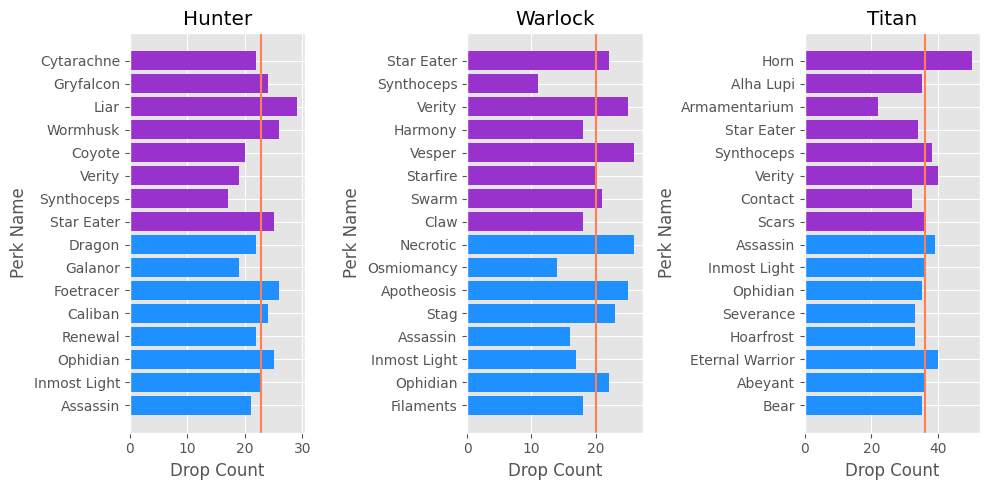

In [62]:
expected = {
    'hunter': 22.75,
    'warlock': 20.13,
    'titan': 35.88
}

fig, ax = plt.subplots(nrows=1,ncols=3, tight_layout = True, figsize=(10,5))

for player_class in perk_drops.class_item.unique():
    temp = perk_drops[perk_drops.class_item == player_class]

    ind = list(perk_drops.class_item.unique()).index(player_class)

    bar_colors = temp.perk_column.map({1:'dodgerblue', 2:'darkorchid'})

    

    ax[ind].barh(temp.perk_name, temp.drops, label = temp.perk_column, color = bar_colors)

    ax[ind].set_title(f"{player_class.title()}")
    ax[ind].set_ylabel("Perk Name")
    ax[ind].set_xlabel("Drop Count")

    # add line for expected value
    ax[ind].axvline(x = expected[player_class], color = 'coral')

plt.savefig(f"outputs/all_classes_perk_drops_bar.png")
plt.show()

The majority of these perks are within 1 standard deviation of the expected number of drops, tenatively, without any testing, I would say its reasonable to assume our 1/8 probability for the whole dataset. 

Now for each of the perks, lets run a binomial proportion test to see if their drop rates are significantly diffrerent than $\frac{1}{8}$

$H_{0} = p_{1} - p_{0} = 0$

$H_{a} = p_{1} - p_{0} \neq 0$

where $p_{1} = p_{perk drop rate}$ and $p_{0} = 0.125$

For this, given the slightly smaller sample and that this is not a rigorous analysis, I'm fine with a lower confidence level, so I'll use $\alpha = 0.1$

I'm essentially only looking to see if I find any evidence to reject my null hypothesis at all. 

In [89]:
p_values = []

for player_class in perk_drops.class_item.unique():
    temp = perk_drops[perk_drops.class_item == player_class]

    # number of observations
    n_obs = int(sum(temp.drops) / 2)

    # for each perk run the test and save the pvalue
    for perk in temp.perk_name:
        p_values.append(binom_test(
            temp[temp['perk_name'] == perk].drops.item(),
            n_obs,
            0.125 
        ))


In [104]:
perk_drops['p_values'] = [round(float(x), 4) for x in p_values]

perk_drops['significant'] = [True if x < 0.1 else False for x in p_values]

In [105]:
perk_drops.head(2)

,class_item,perk_column,perk_name,drops,p_values,significant
0,hunter,1,Assassin,21,0.8224,False
1,hunter,1,Inmost Light,23,0.9109,False


In [106]:
perk_drops[perk_drops.significant == True]

,class_item,perk_column,perk_name,drops,p_values,significant
30,warlock,2,Synthoceps,11,0.0310,True
45,titan,2,Armamentarium,22,0.0121,True
47,titan,2,Horn,50,0.0156,True


Hmm ok, I am able to find evidence to reject my null hypothesis for three perks, two from the Titan class, and one from Warlocks. For every other perk, I do not have sufficient evidence to think that the drop rate would be different from $\frac{1}{8}$.

All three would be rejected at a 99% confidence, but changing your confidence mid test is... frowned upon.

My thought is to go forward with my $p(perkdrop) = \frac{1}{8}$ assumption regardless for the following reasons:

1. It's only 3 perks. Out of 16 for each class (48 total). There's no reason to think that these three specifically have different drop rates. Especially since;
2. The Hunter class isn't represented. I was not able to find evidence that *any* of the Hunter perks were significantly different than the $\frac{1}{8}$ drop rate assumption. 
3. It makes no sense. I think if one perk out of each class had a slightly different drop rate I would proceed differently. But since it appears to be three semi-random selections I'm more inclined to believe it's just some bad luck. Each perk's p-value not being outrageously high gives me more comfort in that decision.

## Testing conclusion

I am not able to test independence between the two perk columns as I do not have access to a reliable dataset with that information. However I believe that I was able to establish that each perk has a $\frac{1}{8}$ chance of dropping individually, for a combined $\frac{1}{64}$ chance of any given perk combination. 

I did find evidence to reject my assumption, that three perks may have a different drop rate, but as addressed above, I am not convinced by this result and will proceed with the assumption that each perk has a $\frac{1}{8}$ chance of dropping.

## Chest Drop Rate

Before getting into simulations, we need to look at one more thing.

There are 2 sources of this exotic class item, with different drop rates for each. The first is the mission *Dual Destiny*, which, if completed, has a 100% item drop rate. The second is chests around the Pale Heart area. These chests have an extremely low chance of dropping an item, and would appear to exist just to give an item every now and then while the player is doing other activities, not to be focus farmed. 

A reddit user farmed 99 of these class items from world chests, posting the data to a reddit thread [here](https://old.reddit.com/r/DestinyTheGame/comments/1dwuj5p/i_farmed_99_class_items_from_pale_heart_chests/). The recorded data is split between three classes again (presumably three seperate characters), and records the drop number, and the number of drops since the previous one. I've converted this into a csv file for easier use in jupyter. You can find that csv in the data folder of this github. 

The presumed drop rate, based entirely on community speculation is 2.5% (0.025). Using this data, I'll quickly examine that claim.

**Assumptions**
- Each chest is independent
    - My assumption here is based on a developer update that indicated that "drop protections" would be added in a future update (e.g. the chance of the item dropping would increase until the player got a drop, then resetting to a baseline value and repeating until the next drop)
- The drop rates are the same across classes.
    - I can examine this using the data provided


In [3]:
world_chests = pd.read_csv("data/world_chests.csv")
world_chests.head(2)

,player_class,drop_no,opened_since_previous_drop,total_chests
0,hunter,1,46,46
1,hunter,2,45,91


In [4]:
world_chests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   player_class                99 non-null     object
 1   drop_no                     99 non-null     int64 
 2   opened_since_previous_drop  99 non-null     int64 
 3   total_chests                99 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 3.2+ KB


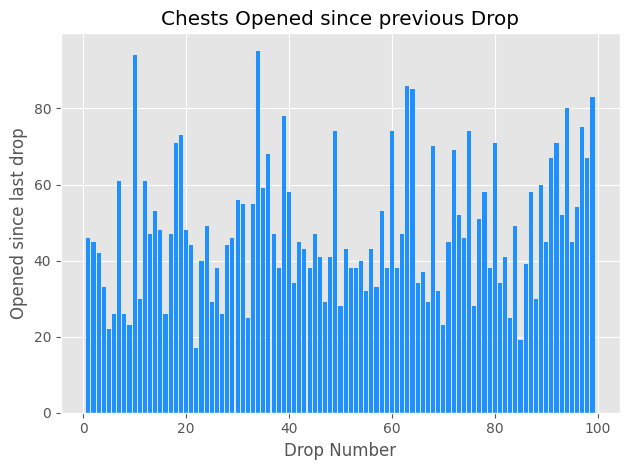

In [16]:
fig,ax=plt.subplots(1,1, tight_layout = True)
ax.bar(world_chests.drop_no, world_chests.opened_since_previous_drop, color = 'dodgerblue')

ax.set_title("Chests Opened since previous Drop")
ax.set_xlabel("Drop Number")
ax.set_ylabel("Opened since last drop")

plt.savefig("outputs/opened_since_last_drop.png")
plt.show()

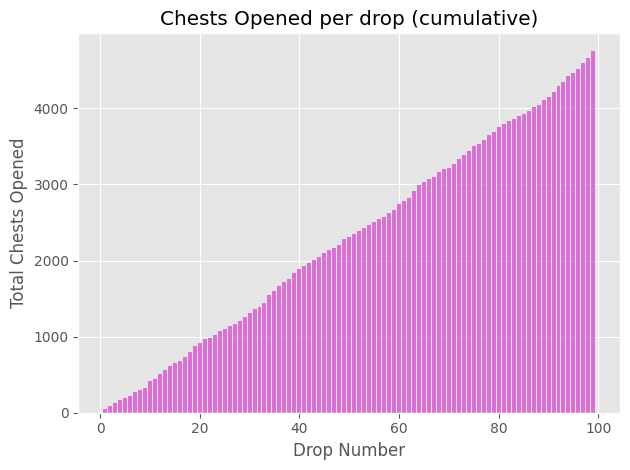

In [15]:
fig,ax = plt.subplots(1,1, tight_layout=True)
ax.bar(world_chests.drop_no, world_chests.total_chests, color = 'orchid')

ax.set_title("Chests Opened per drop (cumulative)")
ax.set_xlabel("Drop Number")
ax.set_ylabel("Total Chests Opened")

plt.savefig("outputs/opened_chests_cumulative.png")
plt.show()

### Comparing Class Drop Rates

In order to proceed with using this data, we really need to establish that the drop rates are not different between classes. 

There are three classes, and comparing proportions across the three is extremely complicated, and does not appear to have a standard testing method. So we can reframe the problem slightly to deal with group means, allowing us to utilize a standard ANOVA test. 

Instead of examining the *drop rate* we can instead examine the *mean number of chests opened* per class, and compare that to ech other. This allows us to sidestep any potential Type 1 errors that may come from repeatedly testing proportions, or fiddling with a test I honestly don't know a lot about. 

We can utilize the ```f_oneway``` from ```scipy.stats``` to achieve this.

In [21]:
# distribution stats
for pc in ['hunter', 'warlock', 'titan']:
    temp = world_chests[world_chests.player_class == pc].opened_since_previous_drop

    print(f"{pc.title()} Summary Stats")
    print(f"Mean: {temp.mean()}")
    print(f"SD: {temp.std()}")
    print("\n")

Hunter Summary Stats
Mean: 43.81818181818182
SD: 16.86982243803737


Warlock Summary Stats
Mean: 49.15151515151515
SD: 18.09717037985706


Titan Summary Stats
Mean: 50.90909090909091
SD: 17.936282426208816




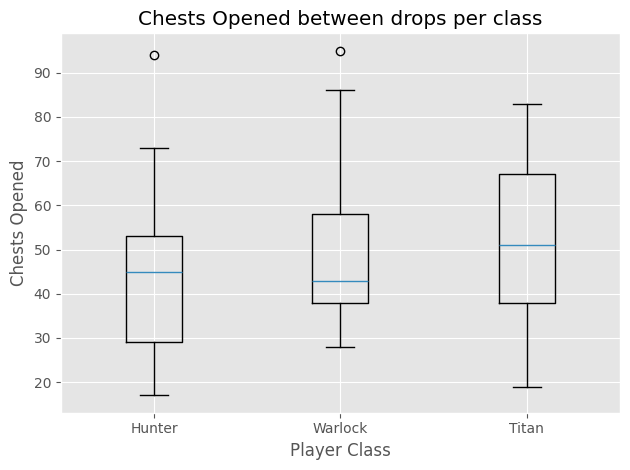

In [26]:
# look at the distributions
dat = [world_chests[world_chests.player_class == 'hunter'].opened_since_previous_drop,
       world_chests[world_chests.player_class == 'warlock'].opened_since_previous_drop,
       world_chests[world_chests.player_class == 'titan'].opened_since_previous_drop]


fig,ax = plt.subplots(1,1, tight_layout = True)
ax.boxplot(dat)

ax.set_title("Chests Opened between drops per class")
ax.set_ylabel("Chests Opened")
ax.set_xlabel("Player Class")
ax.set_xticklabels(['Hunter', 'Warlock', 'Titan'])

plt.savefig("outputs/chests_opened_per_class_boxplot.png")
plt.show()

On just the eye test, these seem similar enough. Lets perform the ANOVA to see if there's any evidence for one or more of these means being different.

$H_{0} = \mu_{hunter} = \mu_{warlock} = \mu_{titan}$

$H_{A} =$ one or more of the sample means is not equal to the others

For this I'm fine with using the usual $\alpha = 0.05$ confidence level

In [30]:
results = f_oneway(world_chests[world_chests.player_class == 'hunter'].opened_since_previous_drop,
       world_chests[world_chests.player_class == 'warlock'].opened_since_previous_drop,
       world_chests[world_chests.player_class == 'titan'].opened_since_previous_drop)

print(f"F-statistic: {results[0]}")
print(f"P-value: {results[1]}")
print(f"Signicant (p <= 0.05): {results[1] <= 0.05}")

F-statistic: 1.445627328613064
P-value: 0.24068033842078213
Signicant (p <= 0.05): False


We have a fairly small F-statistic and a P-value well above our cutoff of 0.05. I think it's save to conclude that we **do not have evidence for the average number of opened chests between drops being significantly different across classes.**

Finally, we can use this information to see if this data gives us evidence to reject the community's hypothetical drop rate of 2.5%. This, again, is a proportion test like we did above for the perk drop rates. I'll skim through the steps here since they're all elaborated on much more above. 

I'll set our confidence at $\alpha = 0.05$

$H_{0} = p_{sample} - p_{hypothetical} = 0$

$H_{A} = p_{sample} - p_{hypothetical} \neq 0$

In [35]:
drop_rate_results = binom_test(99,
           max(world_chests.total_chests),
           0.025
)

print(f"Sample Drop Rate: {99/max(world_chests.total_chests) *100}")
print(f"P-value: {drop_rate_results}")
print(f"Significant (p <= 0.05): {drop_rate_results <= 0.05}")

Sample Drop Rate: 2.0850884582982308
P-value: 0.06967507173467177
Significant (p <= 0.05): False


With this we do not have enough evidence to reject our hypothesis that the world chest drop rate of the Exotic Class item is significantly different than 2.5%. It should be noted that we also do not have evidence to confirm this drop rate, just that we dont have the evidence to say its NOT 2.5%.

We saw that the sample drop rate was much closer to 2% than 2.5% (over a sample of nearly 5,000 chests), so it is reasonable to think it may actually be *lower* than 2.5%. However we did not find evidence of that. For the simulations in the next section I will proceed with the community's original hypothesis that the drop rate is 2.5%.

### Hypothesis Testing Conclusions

This ended up being much longer than I anticipated. At the end of all of this we can confidently say that we have evidence for the following:

1. $p(perk) = \frac{1}{8}$ and by extension, $p(anyClassItemRoll) = \frac{1}{64}$
2. $p(worldChestDrop) = 0.025$

Now we can explore some simulations of class item farms to establish how long it may take to get every possible combination, or to get a specific roll. 

## Simulations